# Exploratory Analysis
### week_03_18_2024 update: 
store_ids = [6, 10, 11, 12, 13, 14, 15]
- Explore the total revenue of each restaurant along each month - try to find patterns, growth KPIs.
- Explore patterns in payments - how many people are dividing the bill or paying total? This is only applicable to the restaurants Cantina Volpi and Ferreiro Café.
- Find new KPIs that can be of interest to the restaurant - new KPIs that can go on a monthly report.

In [1]:
import warnings
# Ignore the warning about the version of SQLAlchemy
warnings.filterwarnings('ignore', message="pandas only supports SQLAlchemy connectable.*")

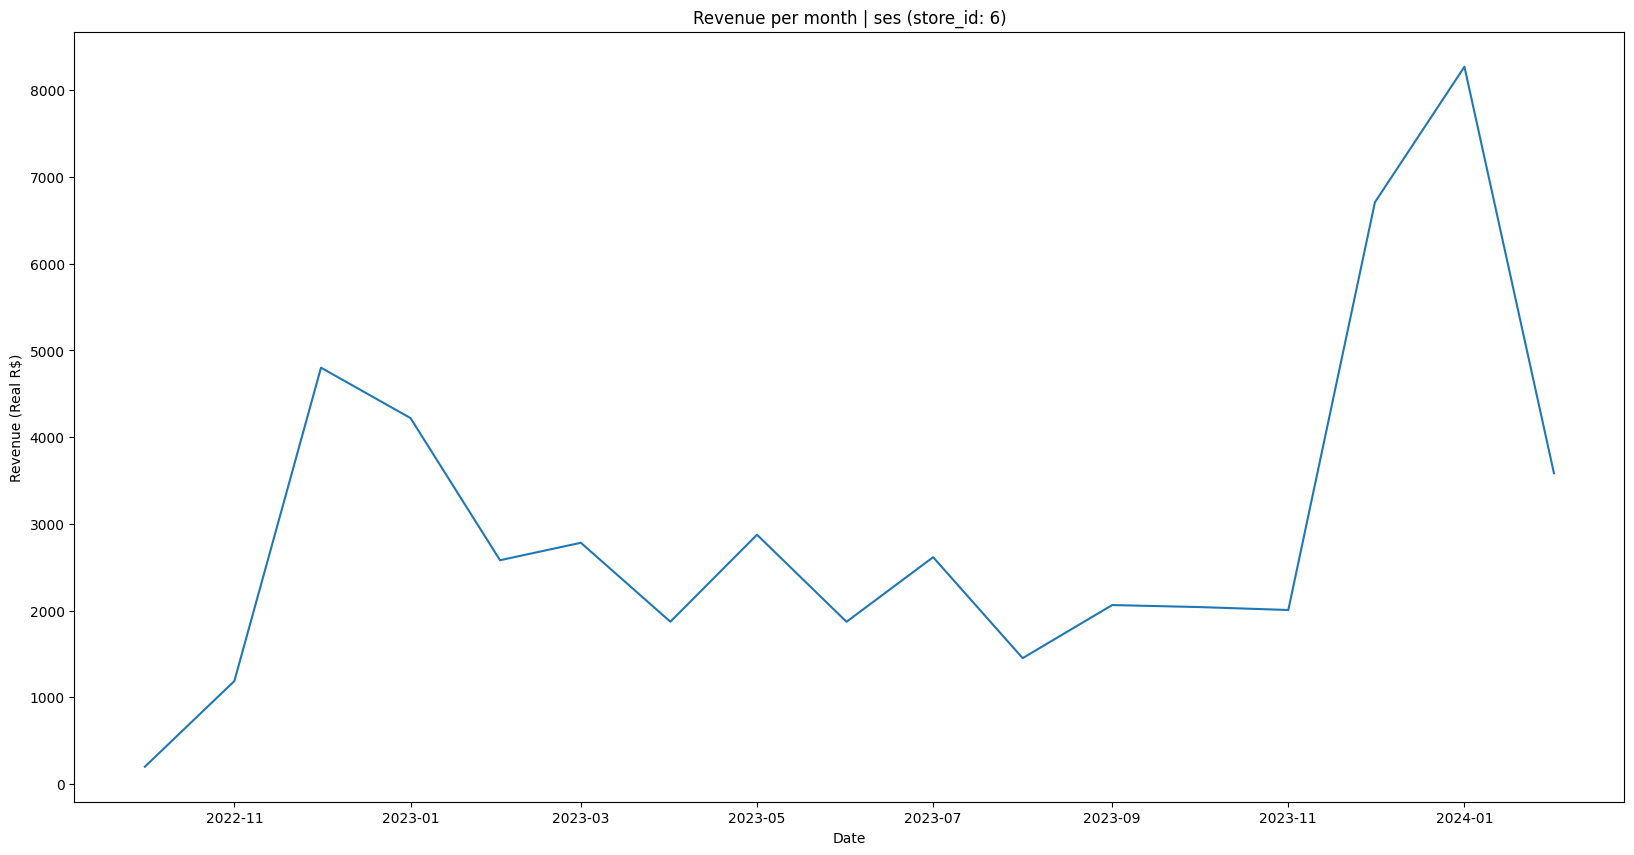

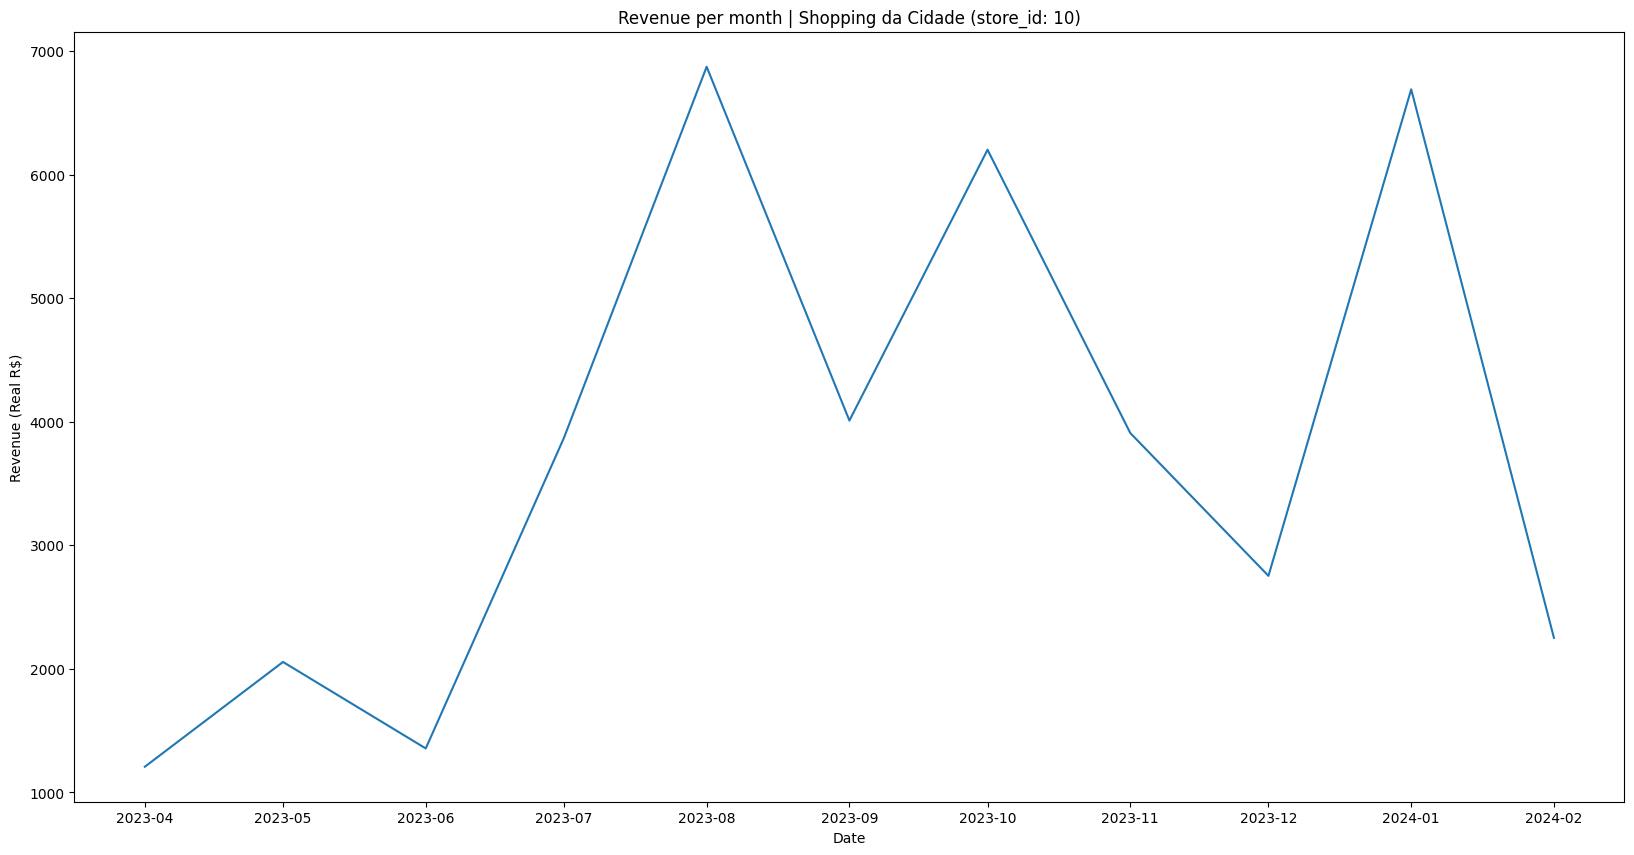

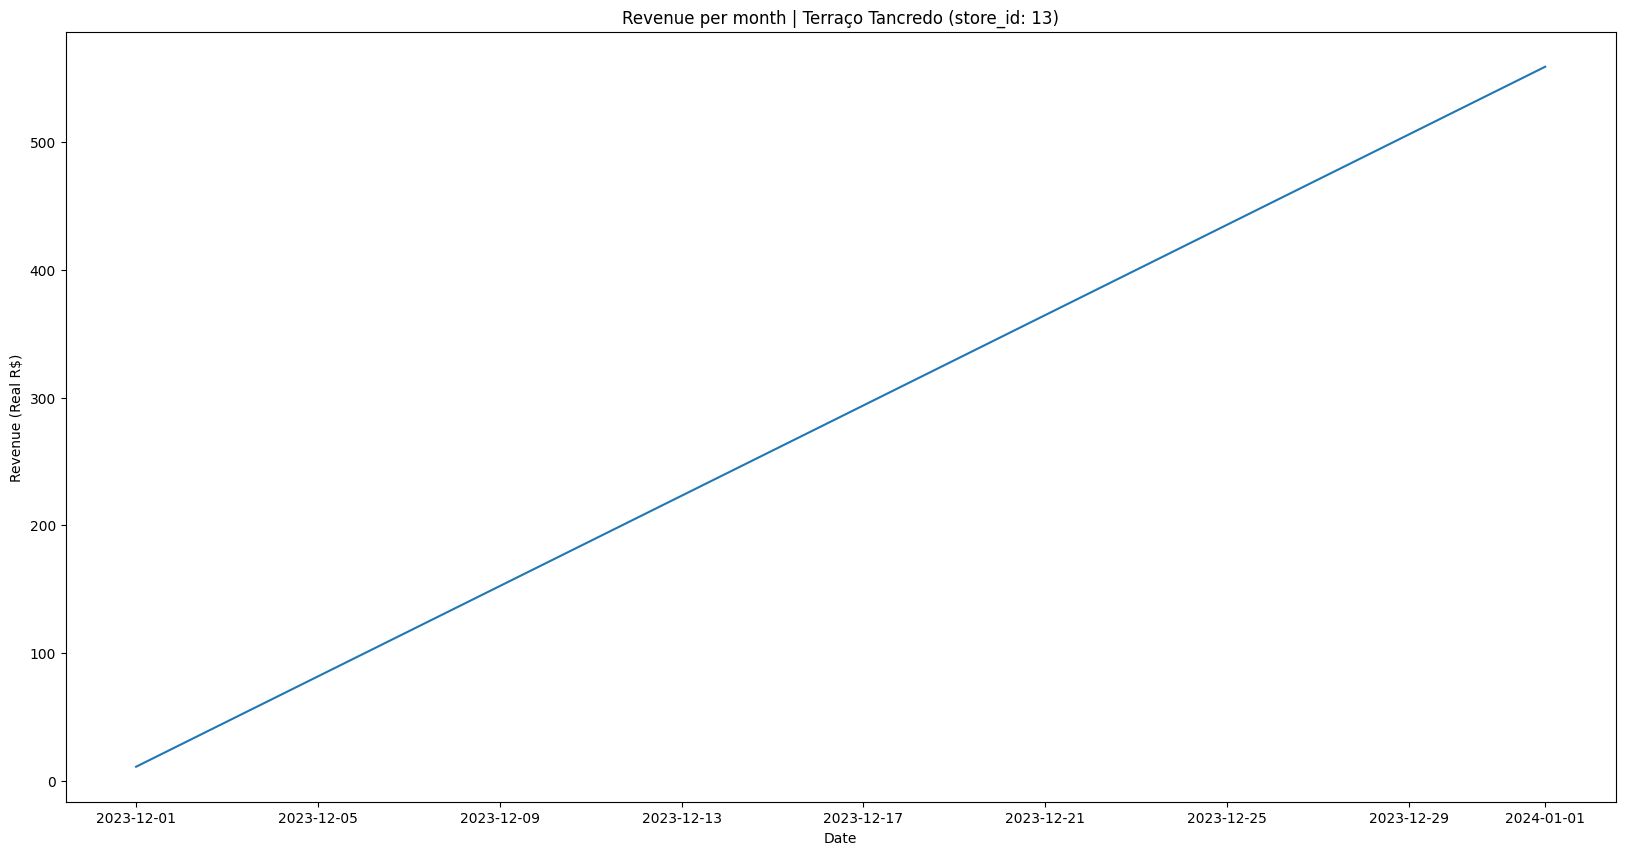

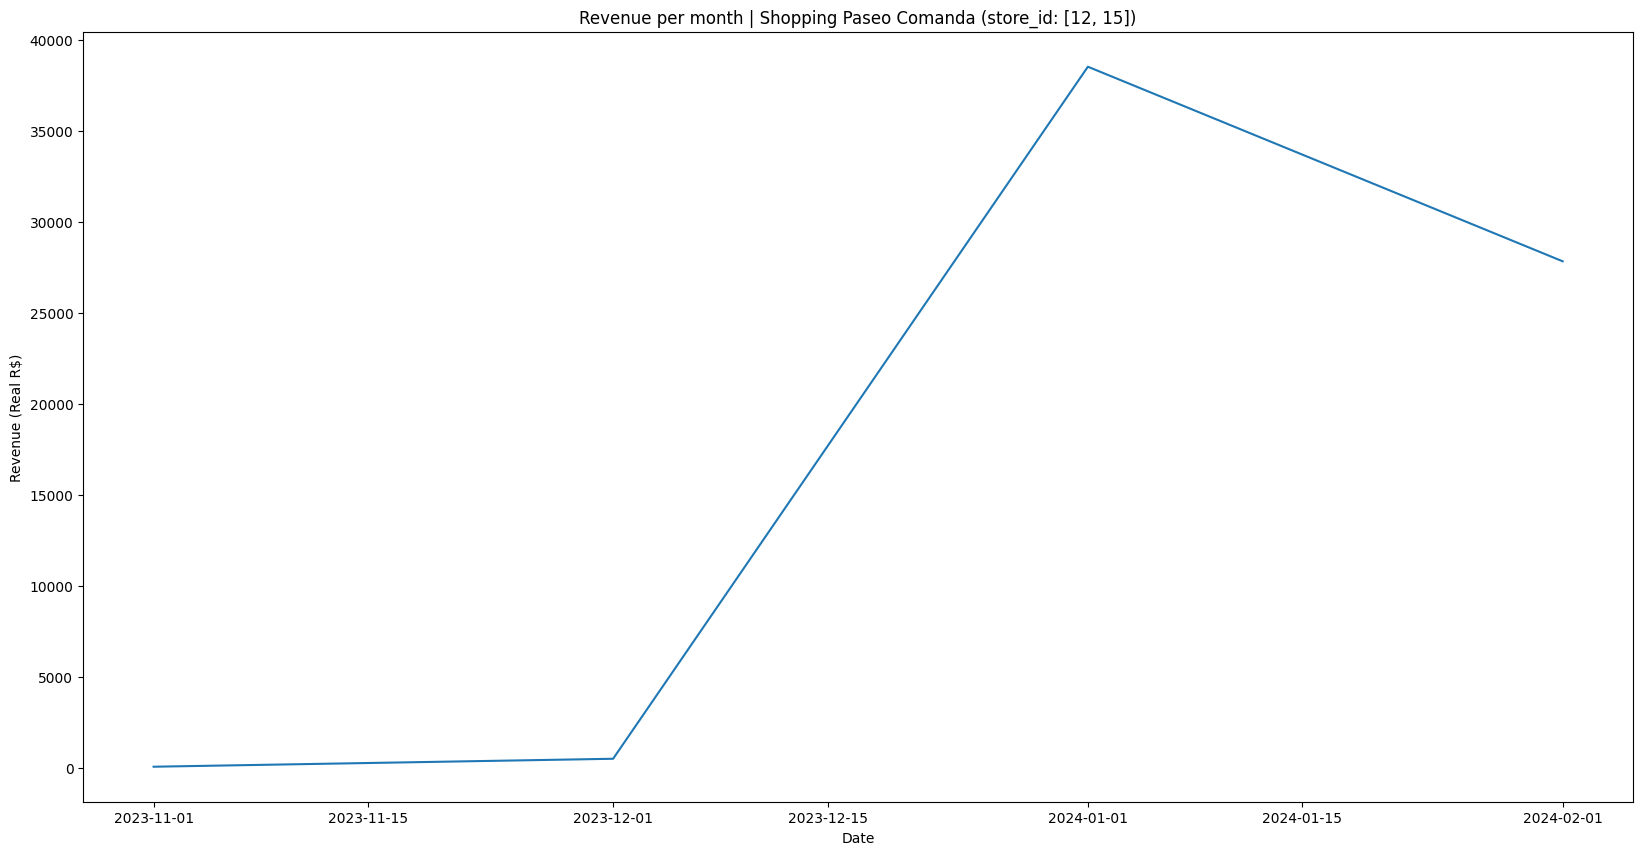

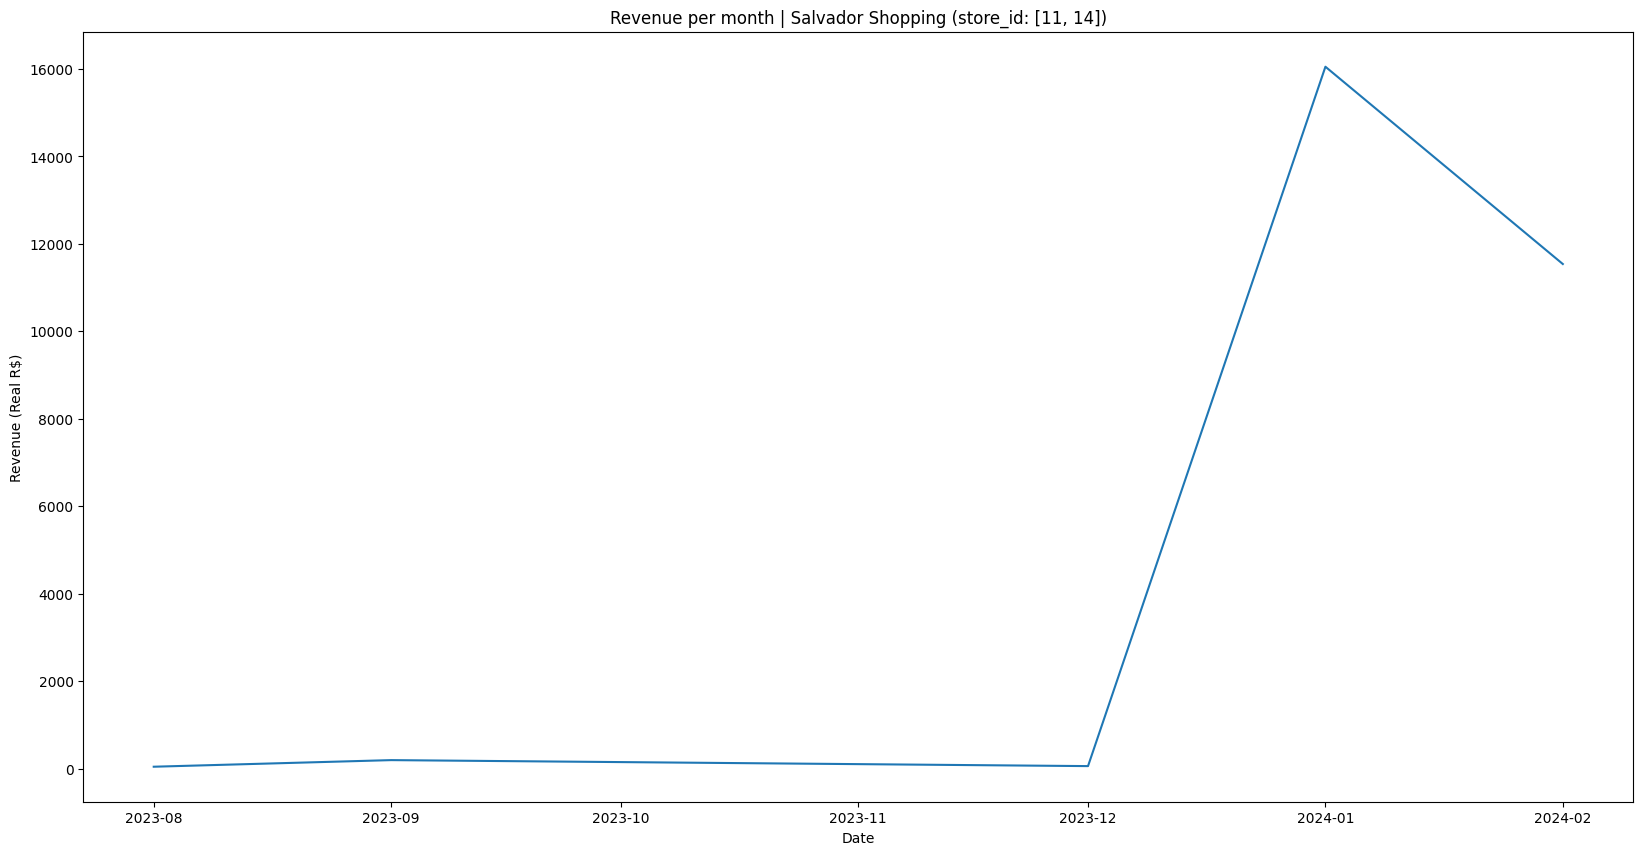

In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

# Store IDs to explore
store_ids = [6, 10, 13]
store_ids_comb = [[12, 15], [11, 14]]
# Database connection parameters
db_params = {
    'dbname': 'payby',
    'user': 'postgres',
    'password': '2458',
    'host': 'localhost',
    'port': '5432'
}

def get_all_store_ids():
    query = "SELECT id FROM core_store;"
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    try:
        cur.execute(query)
        store_ids = [store[0] for store in cur.fetchall()]
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        store_ids = []
    finally:
        cur.close()
        conn.close()
    return store_ids

def get_store_name(store_id):
    query = f"SELECT name FROM core_store WHERE id = {store_id};"
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    try:
        cur.execute(query)
        store_name = cur.fetchone()[0]
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        store_name = None
    finally:
        cur.close()
        conn.close()
    return store_name

# Explore the total revenue of each restaurant along each month - try to find patterns, growth KPIs.
def get_confirmed_payments(store_id):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    # Modify this query to select only the relevant columns for revenue
    query = f"""
        SELECT 
            EXTRACT(MONTH FROM cp.ts_confirmed) AS month,
            EXTRACT(YEAR FROM cp.ts_confirmed) AS year,
            SUM(cp.payment_total) AS revenue  -- Replace 'cp.payment_total' with your actual revenue column
        FROM "core_payment" cp
        INNER JOIN "core_ticket" ON ("cp"."ticket_id" = "core_ticket"."id") 
        INNER JOIN "core_store" ON ("core_ticket"."store_id" = "core_store"."id") 
        WHERE "core_store"."id" = {store_id}
        AND "cp"."ts_refunded" IS NULL
        AND "cp"."ts_confirmed" IS NOT NULL
        GROUP BY month, year
        ORDER BY year, month;
    """
    cur.execute(query)
    results = cur.fetchall()
    cur.close()
    conn.close()
    return results

def get_confirmed_payments_multi(store_id_list):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    # Modify this query to select only the relevant columns for revenue
    query = f"""
        SELECT 
            EXTRACT(MONTH FROM cp.ts_confirmed) AS month,
            EXTRACT(YEAR FROM cp.ts_confirmed) AS year,
            SUM(cp.payment_total)/100 AS revenue  -- Replace 'cp.payment_total' with your actual revenue column
        FROM "core_payment" cp
        INNER JOIN "core_ticket" ON ("cp"."ticket_id" = "core_ticket"."id") 
        INNER JOIN "core_store" ON ("core_ticket"."store_id" = "core_store"."id") 
        WHERE "core_store"."id" IN ({','.join([str(store_id) for store_id in store_id_list])})
        AND "cp"."ts_refunded" IS NULL
        AND "cp"."ts_confirmed" IS NOT NULL
        GROUP BY month, year
        ORDER BY year, month;
    """
    cur.execute(query)
    results = cur.fetchall()
    cur.close()
    conn.close()
    return results

def average_revenue_per_month(results):
    total_revenue = sum([result[2] for result in results])
    if len(results) == 0: return 0
    average_revenue = total_revenue / len(results)
    return average_revenue

full_store_list = get_all_store_ids()
for store_id in store_ids:
    if store_id not in full_store_list:
        print(f"store_id {store_id} not found")
        continue
    store_name = get_store_name(store_id)
    revenue = get_confirmed_payments(store_id)
    df = pd.DataFrame(revenue, columns=['month', 'year', 'revenue'])
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    df = df.sort_values('date')

    plt.figure(figsize=(20, 10))
    plt.xlabel('Date')
    plt.ylabel('Revenue (Real R$)')
    plt.title(f"Revenue per month | {store_name} (store_id: {store_id})")
    plt.plot(df['date'], df['revenue'])
    plt.show()

for store_id_list in store_ids_comb:
    for store_id in store_id_list:
        if store_id not in full_store_list:
            print(f"store_id {store_id} not found")
            continue
    store_name = get_store_name(store_id_list[0])
    revenue = get_confirmed_payments_multi(store_id_list)
    df = pd.DataFrame(revenue, columns=['month', 'year', 'revenue'])
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    df = df.sort_values('date')

    plt.figure(figsize=(20, 10))
    plt.xlabel('Date')
    plt.ylabel('Revenue (Real R$)')
    plt.title(f"Revenue per month | {store_name} (store_id: {store_id_list})")
    plt.plot(df['date'], df['revenue'])
    plt.show()

-------------------------- No change from last time --------------------------

### Store IDs to explore
store_ids = [6, 10, 13]
store_ids_comb = [[12, 15], [11, 14]]

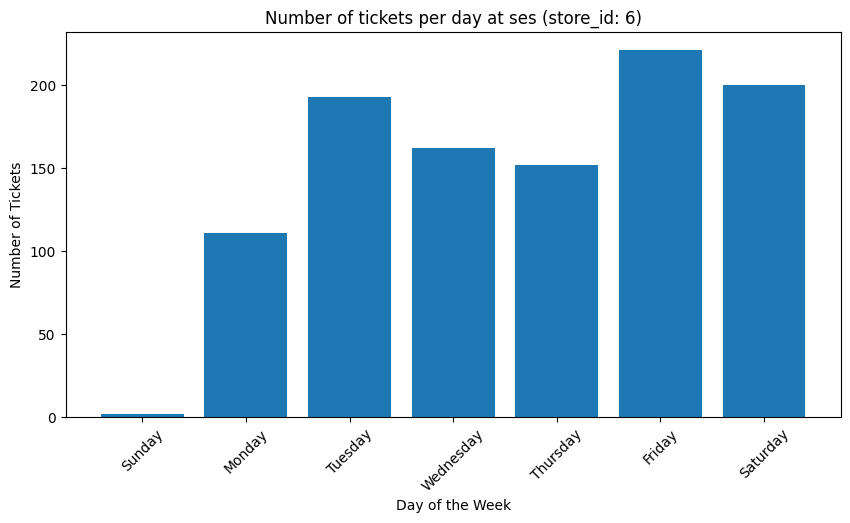

The best day to visit ses (store_id: 6) is Friday.


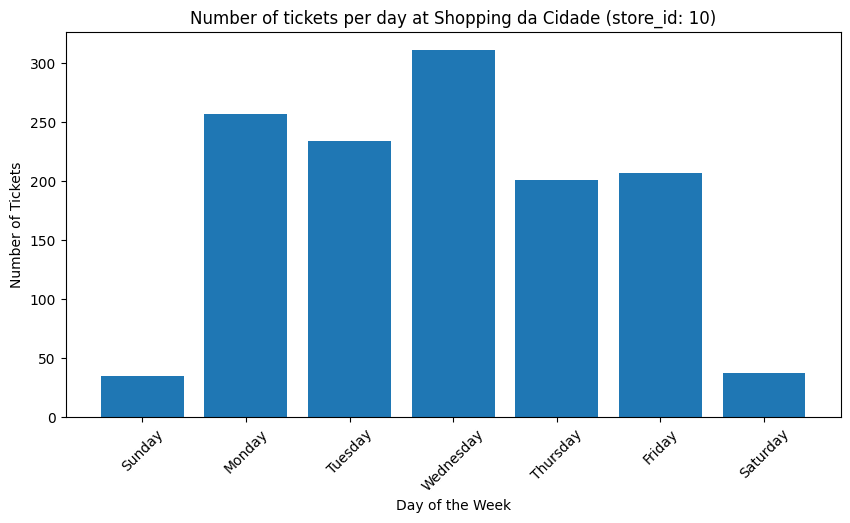

The best day to visit Shopping da Cidade (store_id: 10) is Wednesday.


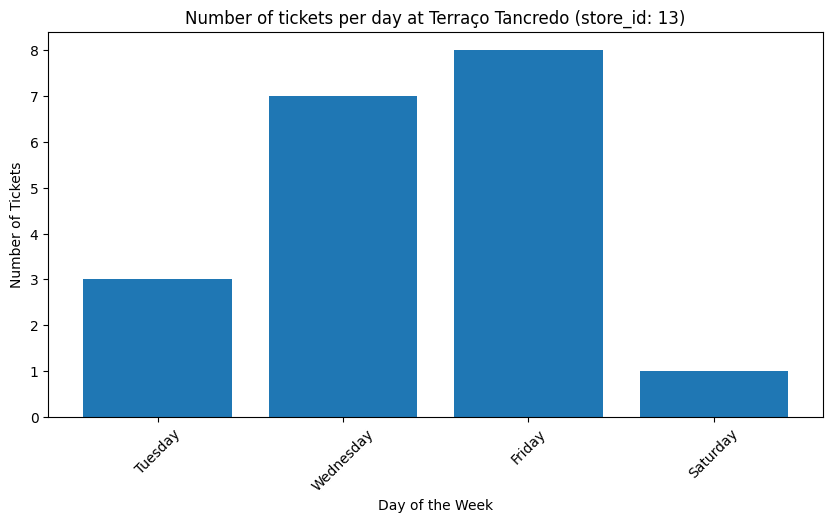

The best day to visit Terraço Tancredo (store_id: 13) is Friday.


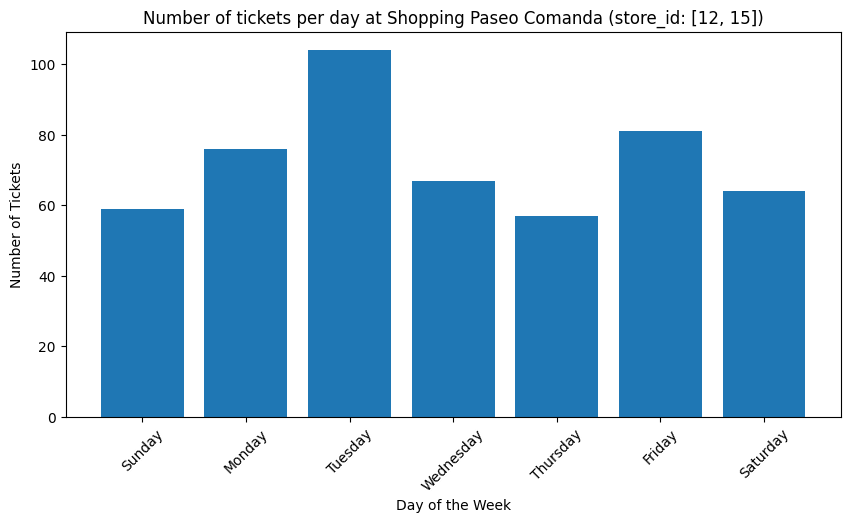

The best day to visit Shopping Paseo Comanda (store_id: [12, 15]) is Tuesday.


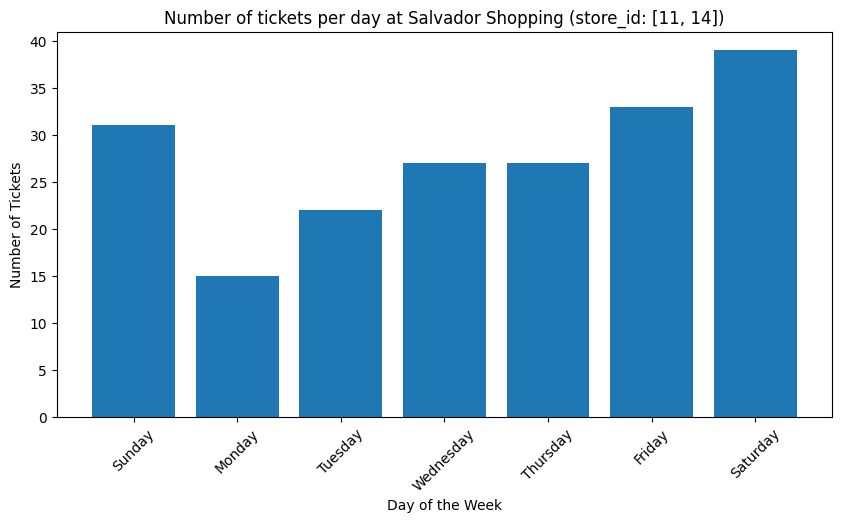

The best day to visit Salvador Shopping (store_id: [11, 14]) is Saturday.


In [8]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

# get the total number of tickets per day of the week
def get_tickets_per_day(store_id):
    query = f"""
    SELECT EXTRACT(DOW FROM ct.dt_created) AS day_of_week, COUNT(*) AS count
    FROM core_ticket ct
    INNER JOIN core_payment cp ON cp.ticket_id = ct.id
    WHERE ct.store_id = {store_id}
    AND cp.ts_refunded IS NULL
    AND cp.ts_confirmed IS NOT NULL
    GROUP BY day_of_week
    ORDER BY day_of_week;
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

def get_tickets_per_day_multi(store_id_list):
    if len(store_id_list) == 1:
        return get_tickets_per_day(store_id_list[0])
    query = f"""
    SELECT EXTRACT(DOW FROM ct.dt_created) AS day_of_week, COUNT(*) AS count
    FROM core_ticket ct
    INNER JOIN core_payment cp ON cp.ticket_id = ct.id
    WHERE ct.store_id IN {tuple(store_id_list)}
    AND cp.ts_refunded IS NULL
    AND cp.ts_confirmed IS NOT NULL
    GROUP BY day_of_week
    ORDER BY day_of_week;
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

day_names = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
def get_best_day_to_visit(df):
    df['day_name'] = df['day_of_week'].map(day_names)
    best_day = df[df['count'] == df['count'].max()]['day_name'].values[0]
    return best_day

def plot_tickets_per_day(df, store_name, store_id):
    df['day_name'] = df['day_of_week'].map(day_names)
    
    plt.figure(figsize=(10, 5))
    plt.bar(df['day_name'], df['count'], align='center')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Tickets')
    plt.title(f'Number of tickets per day at {store_name} (store_id: {store_id})')
    plt.xticks(rotation=45)
    plt.show()

for store_id in store_ids:
    df = get_tickets_per_day(store_id)
    if not df.empty:
        best_day = get_best_day_to_visit(df)
        store_name = get_store_name(store_id)
        plot_tickets_per_day(df, store_name, store_id)
        print(f"The best day to visit {store_name} (store_id: {store_id}) is {best_day}.")
    else:
        print(f"No tickets found for store_id: {store_id}.")
        
for store_id in store_ids_comb:
    df = get_tickets_per_day_multi(store_id)
    if not df.empty:
        best_day = get_best_day_to_visit(df)
        store_name = get_store_name(store_id[0])
        plot_tickets_per_day(df, store_name, store_id)
        print(f"The best day to visit {store_name} (store_id: {store_id}) is {best_day}.")
    else:
        print(f"No tickets found for store_id: {store_id}.")


### Store IDs to explore
store_ids = [6, 10, 13]
store_ids_comb = [[12, 15], [11, 14]]

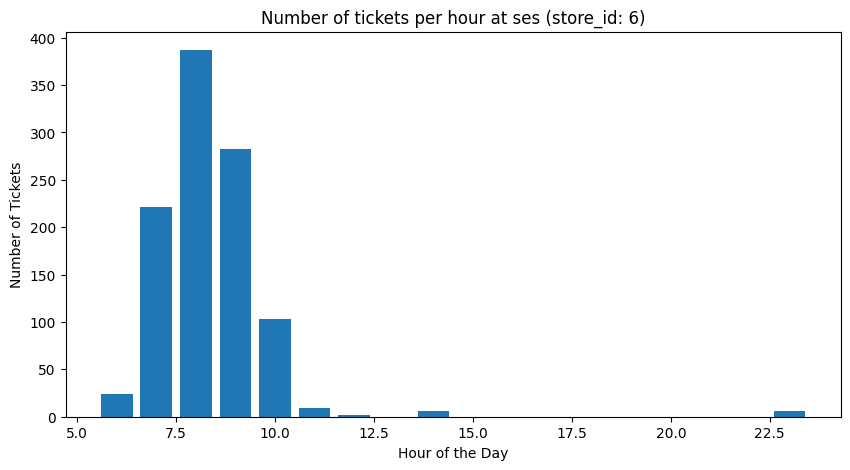

The busiest hour at ses (store_id: 6) is 8:00.


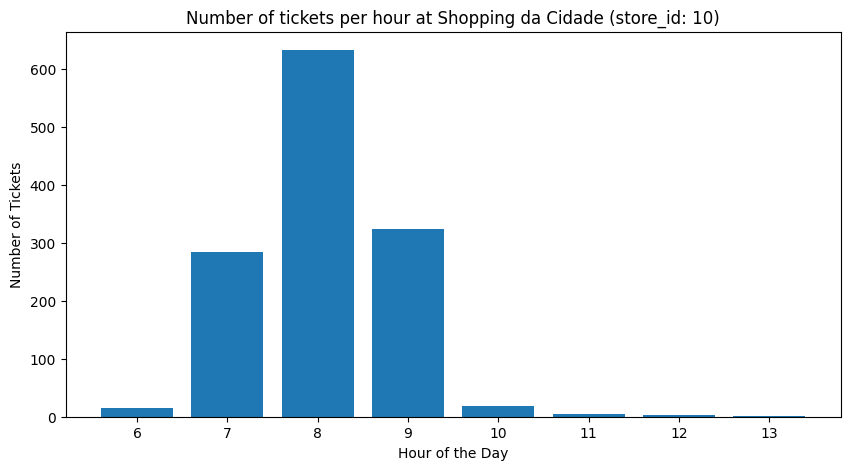

The busiest hour at Shopping da Cidade (store_id: 10) is 8:00.


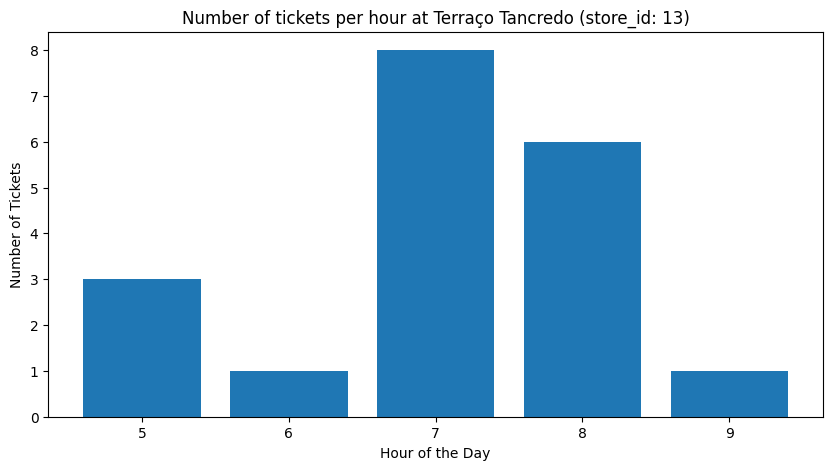

The busiest hour at Terraço Tancredo (store_id: 13) is 7:00.


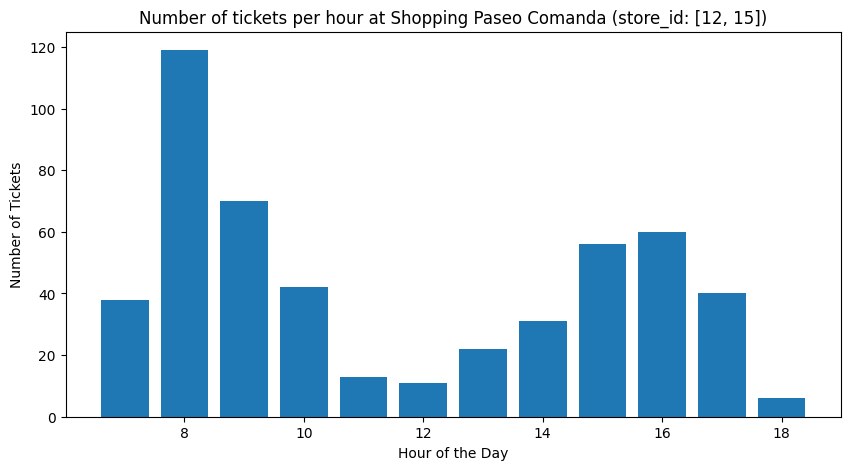

The busiest hour at Shopping Paseo Comanda (store_id: [12, 15]) is 8:00.


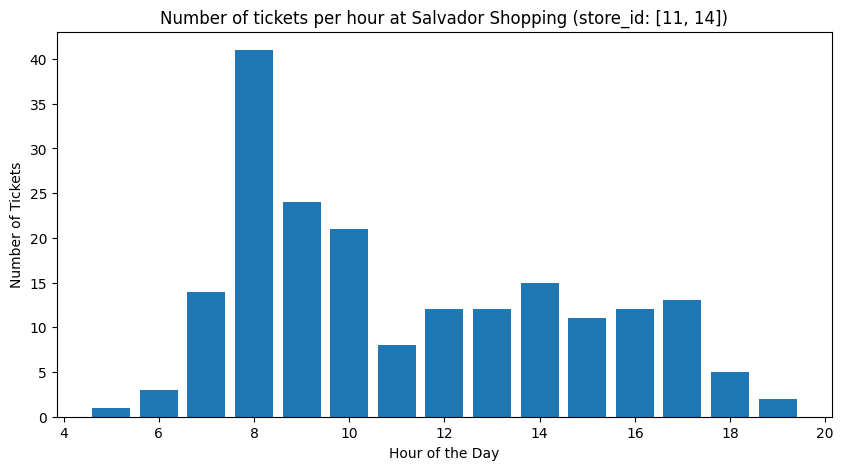

The busiest hour at Salvador Shopping (store_id: [11, 14]) is 8:00.


In [9]:
# print the ts_created column of the core_ticket table
def get_ticket_creation_times(store_id):
    query = f"""
    SELECT EXTRACT(HOUR FROM ct.ts_created) AS hour, COUNT(*) AS count
    FROM core_ticket ct
    INNER JOIN core_payment cp ON cp.ticket_id = ct.id
    WHERE ct.store_id = {store_id}
    AND cp.ts_refunded IS NULL
    AND cp.ts_confirmed IS NOT NULL
    GROUP BY hour
    ORDER BY hour;
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

def get_ticket_creation_times_multi(store_id_list):
    if len(store_id_list) == 1:
        return get_ticket_creation_times(store_id_list[0])
    query = f"""
    SELECT EXTRACT(HOUR FROM ct.ts_created) AS hour, COUNT(*) AS count
    FROM core_ticket ct
    INNER JOIN core_payment cp ON cp.ticket_id = ct.id
    WHERE ct.store_id IN {tuple(store_id_list)}
    AND cp.ts_refunded IS NULL
    AND cp.ts_confirmed IS NOT NULL
    GROUP BY hour
    ORDER BY hour;
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

def plot_tickets_per_hour(df, store_name, store_id):
    plt.figure(figsize=(10, 5))
    plt.bar(df['hour'], df['count'], align='center')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Tickets')
    plt.title(f'Number of tickets per hour at {store_name} (store_id: {store_id})')
    plt.show()

# plot the number of tickets created per hour
# and print the buiziets hour of the day
for store_id in store_ids:
    df = get_ticket_creation_times(store_id)
    if not df.empty:
        busiest_hour = df[df['count'] == df['count'].max()]['hour'].values[0]
        store_name = get_store_name(store_id)
        plot_tickets_per_hour(df, store_name, store_id)
        print(f"The busiest hour at {store_name} (store_id: {store_id}) is {int(busiest_hour)}:00.")
    else:
        print(f"No tickets found for store_id: {store_id}.")
        
for store_id in store_ids_comb:
    df = get_ticket_creation_times_multi(store_id)
    if not df.empty:
        busiest_hour = df[df['count'] == df['count'].max()]['hour'].values[0]
        store_name = get_store_name(store_id[0])
        plot_tickets_per_hour(df, store_name, store_id)
        print(f"The busiest hour at {store_name} (store_id: {store_id}) is {int(busiest_hour)}:00.")
    else:
        print(f"No tickets found for store_id: {store_id}.")


Explore patterns in payments - how many people are dividing the bill or paying total? This is only applicable to the restaurants Cantina Volpi and Ferreiro Café.

In [16]:
for store_id in full_store_list:
    name = get_store_name(store_id)
    print(f"store_id: {store_id}, name: {name}")

intersted_store_ids = [16, 17]
def analyze_payment_patterns(store_id):
    query = f"""
    SELECT * 
    FROM core_ticket ct
    WHERE ct.store_id = {store_id}
    LIMIT 10
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

for store_id in intersted_store_ids:
    df = analyze_payment_patterns(store_id)
    print(df)

store_id: 1, name: payby
store_id: 6, name: ses
store_id: 8, name: Menew
store_id: 9, name: Saúde na Panela
store_id: 10, name: Shopping da Cidade
store_id: 11, name: Salvador Shopping
store_id: 12, name: Shopping Paseo Comanda
store_id: 13, name: Terraço Tancredo
store_id: 14, name: Salvador Shopping Comanda
store_id: 15, name: Shopping Paseo Mesa
store_id: 7, name: Menew Sandbox
store_id: 16, name: Cantina Volpi Ondina Mesa
store_id: 17, name: Cantina Volpi Ondina Comanda
Empty DataFrame
Columns: [id, ticket_pdv_id, table, ts_created, dt_created, is_paid, app_paid, paid_value, ts_paid, table_total, items, api_props, store_id, pdv_reference_id]
Index: []
Empty DataFrame
Columns: [id, ticket_pdv_id, table, ts_created, dt_created, is_paid, app_paid, paid_value, ts_paid, table_total, items, api_props, store_id, pdv_reference_id]
Index: []
